In [4]:
import numpy as np
from matplotlib import pyplot as plt
import os
import torch
from torchvision import datasets
import torchvision.transforms as transforms

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as utils
import torch.utils.data as td
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision import datasets
import torchvision.transforms as transforms
from PIL import Image

In [2]:
data_dir = "C:\\Users\DELL\Documents\major projects\datasets"
os.listdir(data_dir)

['images', 'imagessample.rar', 'images_001.tar.gz']

In [3]:
data_dir = "C:\\Users\DELL\Documents\major projects\datasets"

In [5]:
train_dir = data_dir
img_size = 256
transform_train = transforms.Compose([transforms.Resize(img_size),transforms.ToTensor()])
train_data = torchvision.datasets.ImageFolder(train_dir, transform = transform_train)
                                     

In [6]:

# 1
num_workers = 0
# 2
batch_size = 10
# 3
transform = transforms.ToTensor()
# 4
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
 num_workers=num_workers)

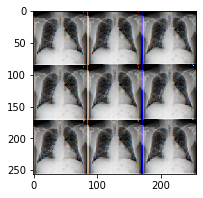

In [7]:
#1 
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
#2
img = np.squeeze(images[0]).reshape([256,256, 3])
#img = images[0]
#print(train_loader)
fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img)


In [8]:
import cv2
img1=img.flatten()
img1.shape

(196608,)

In [9]:
import torch.nn as nn
import torch.nn.functional as F
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
 
          
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 256*256)
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer
        out = self.fc4(x)

        return out

In [10]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
 
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = F.tanh(self.fc4(x))

        return out

In [11]:
# Discriminator hyperparameters
# 1
input_size = 65536
# 2
d_output_size = 1
# 3
d_hidden_size = 64
# Generator hyperparams
# 4
z_size = 100
# 5
g_output_size = 65536
# 6
g_hidden_size = 64

In [12]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)
# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=65536, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=65536, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [13]:
# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
 # label smoothing
    if smooth:
 # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
 
 # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
 # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss
def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
 # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [14]:
import torch.optim as optim
lr = 0.001
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [15]:
import pickle as pkl

# training hyperparams
num_epochs = 100

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

C:\Users\DELL\Anaconda3\lib\site-packages\torch\nn\functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  100] | d_loss: 1.3874 | g_loss: 0.7329
Epoch [    2/  100] | d_loss: 2.1176 | g_loss: 0.7782
Epoch [    3/  100] | d_loss: 1.4227 | g_loss: 0.8895
Epoch [    4/  100] | d_loss: 1.4323 | g_loss: 1.0373
Epoch [    5/  100] | d_loss: 1.0675 | g_loss: 1.1181
Epoch [    6/  100] | d_loss: 1.3059 | g_loss: 1.1652
Epoch [    7/  100] | d_loss: 1.3366 | g_loss: 1.1063
Epoch [    8/  100] | d_loss: 1.4466 | g_loss: 0.7995
Epoch [    9/  100] | d_loss: 1.4494 | g_loss: 0.6123
Epoch [   10/  100] | d_loss: 1.5601 | g_loss: 0.5688
Epoch [   11/  100] | d_loss: 1.6760 | g_loss: 0.5037
Epoch [   12/  100] | d_loss: 1.6761 | g_loss: 0.4372
Epoch [   13/  100] | d_loss: 1.8806 | g_loss: 0.4846
Epoch [   14/  100] | d_loss: 1.8034 | g_loss: 0.5672
Epoch [   15/  100] | d_loss: 1.7452 | g_loss: 0.7827
Epoch [   16/  100] | d_loss: 1.2276 | g_loss: 1.1257
Epoch [   17/  100] | d_loss: 1.2344 | g_loss: 1.4800
Epoch [   18/  100] | d_loss: 0.9723 | g_loss: 2.1948
Epoch [   19/  100] | d_loss

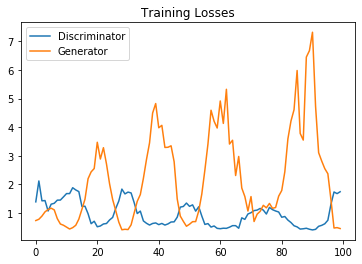

In [16]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [18]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((256,256)), cmap='Greys_r')

In [19]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

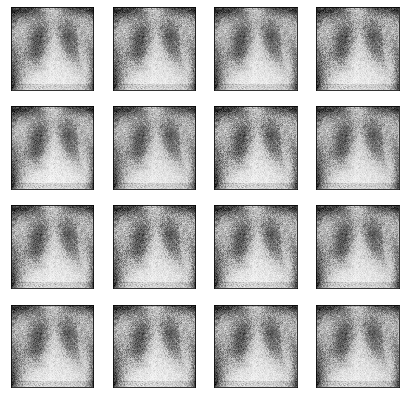

In [20]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

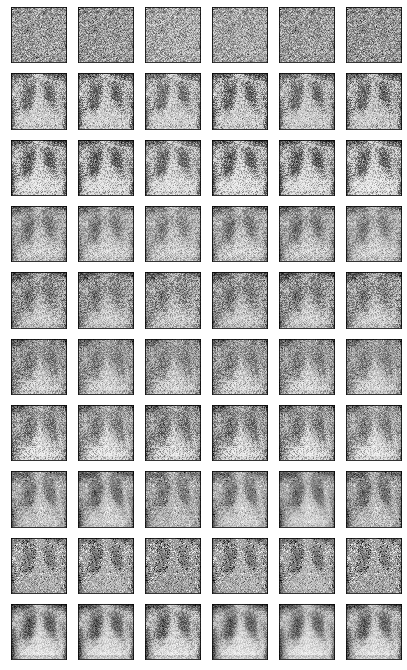

In [21]:

rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((256,256)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

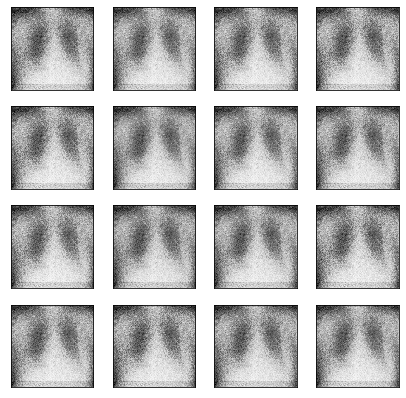

In [22]:

# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])